# 🏷️ Part 1.1 – Categorizing Job Titles Using a Rule-Based Approach

**Author:** Yu Kyung Koh  
**Last Updated:** July 5, 2025  

---

### 🎯 Objective

* This notebook imports raw job posting data, explores the structure of job titles, and applies a rule-based classification method using regular expressions.
* The goal is to assign job titles to predefined categories such as **Data-related**, **Software Development**, **Consulting**, **Finance**, and others.
* While job category labels are known by design—assigned during the LLM-based generation of synthetic job postings ([details here](https://github.com/yukyungkoh/job-postings-data-project/tree/main/0_generate-synthetic-job-postings)) -- they are treated as unknown here to demonstrate how a rule-based classification approach can be applied in practice.
  
### 🗂️ Outline
* Section 1: Import the job posting data
* Section 2: Investigate job titles
* Section 3: Rule-based approach in categorizing job title

---
## SECTION 1: Import job posting data

In [3]:
import pandas as pd
import numpy as np
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
datadir = '../data/'
jobposting_file = os.path.join(datadir, 'synthetic_job_postings_combined.csv')

posting_df = pd.read_csv(jobposting_file)

posting_df.head()

,job_title,posting_text,sector
0,Educational Program Coordinator,We are seeking an enthusiastic Educational Pro...,education
1,Healthcare Data Analyst,We are seeking a detail-oriented Healthcare Da...,healthcare
2,Strategic Operations Consultant,"**Location:** Hybrid (New York, NY) \n**Salar...",consulting
3,Financial Operations Specialist,"**Location:** Hybrid (New York City, NY) \n**...",finance
4,Marketing Data Analyst,We are seeking a detail-oriented Marketing Dat...,marketing


In [5]:
## Get statistics about each column of the df 
posting_df.describe(include='all')

,job_title,posting_text,sector
count,10877,10877,10877
unique,579,10877,11
top,Sales Development Representative,We are seeking an enthusiastic Educational Pro...,data science
freq,535,1,1054


In [6]:
## Rename "sector" as "true_category"
posting_df.rename(columns={'sector': 'true_category'}, inplace=True)

---
## SECTION 2: Investigate Job Titles

* Before applying a rule-based classification approach, I begin by examining the job titles in the dataset.
* I analyze the most common unigrams and bigrams to guide the design of keyword patterns used for categorization.
* This step helps identify and filter out uninformative terms (e.g., "II", "Sr.") that could otherwise lead to misclassification in the rule-based method.

In [8]:
## First, check out the number of unique job titles 

unique_titles = posting_df['job_title'].unique()
num_unique_titles = posting_df['job_title'].nunique()

print('There are ', num_unique_titles, ' unique job titles in this data.')

There are  579  unique job titles in this data.


### 🔷  View Top Unigrams in Job Titles

In [10]:
# --------------------------------------
# STEP 1: Clean and tokenize job titles
# --------------------------------------
def clean_and_tokenize(title):
    if not isinstance(title, str):
        return []

    # Lowercase and remove numbers/special characters (except spaces)
    title_clean = re.sub(r'[^a-zA-Z\s]', '', title.lower())
    
    # re.sub( [what to replace] ,'', object)
    #      replaces any [what to replace] to an empty string ('') inside the 'object'
    #        r'[^a-zA-Z\s]'
    #          ^ : anything that is NOT
    #          a-zA-Z : uppercase and lowercase letters
    #          \s : whitespace character
    
    # Tokenize (split into words)
    words = title_clean.split()

    # Remove common stopwords
    stopwords = {"and", "of", "the", "in", "to", "for", "with", "a", "on", "at", "as"}
    words = [word for word in words if word not in stopwords]

    return words

# --------------------------------------
# STEP 2: Apply to all job titles
# --------------------------------------
all_words = posting_df["job_title"].dropna().apply(clean_and_tokenize)

In [11]:
# --------------------------------------
# STEP 3: Count word frequencies
# --------------------------------------
flat_words = [word for sublist in all_words for word in sublist] 
word_counts = Counter(flat_words)

In [12]:
# --------------------------------------
# STEP 4: Convert to DataFrame for plotting
# -------------------------------------- 
top_words_df = pd.DataFrame(word_counts.most_common(30), columns=["keyword", "count"])

<Figure size 1200x1000 with 0 Axes>

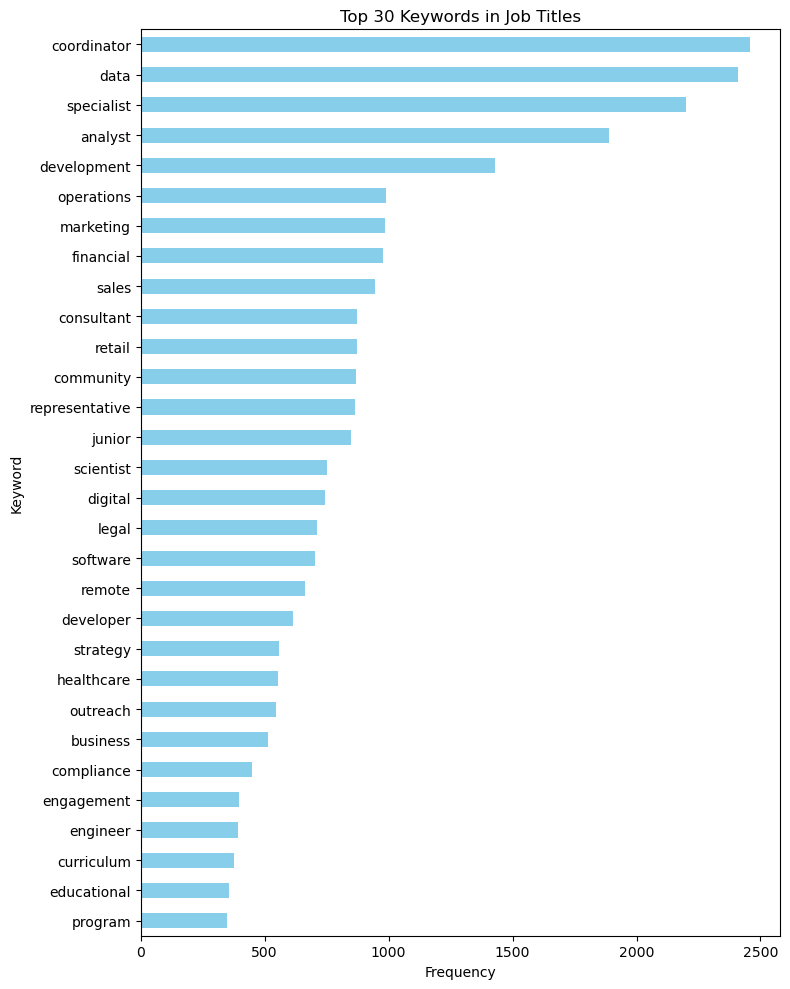

In [13]:
# --------------------------------------
# STEP 5: Bar Plot for top unigrams
# -------------------------------------- 
# => Plot top 30 keywords
plt.figure(figsize=(12, 10))  # Adjust size for better readability
top_words_df.plot(kind='barh', x='keyword', y='count', legend=False, color='skyblue', figsize=(8, 10))
plt.title("Top 30 Keywords in Job Titles")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.gca().invert_yaxis()  # Most frequent at top
plt.tight_layout()
plt.show()

### 🔷  View Top Bigrams in Job Titles

* In the previous step, we saw that common unigrams in job titles include terms like "data" and "analyst."  
* While informative, these single-word keywords are often too broad to reliably infer job function. For example, the term **"engineer"** could refer to vastly different roles such as *software engineer* or *chemical engineer*.
* To gain more meaningful insights, I now examine **bigrams** -- pairs of consecutive words such as *data scientist* or *software engineer* -- which can offer more specific signals for classification

In [15]:
# --------------------------------------
# STEP 1: Clean job titles
# --------------------------------------  
def clean_title(title):
    if not isinstance(title, str):
        return ""
    title = title.lower()
    title = re.sub(r'[^a-z\s]', '', title)  # remove punctuation/numbers
    return title

cleaned_titles = posting_df["job_title"].dropna().apply(clean_title)


In [16]:
# --------------------------------------
# STEP 2: Add custom stopwords
# --------------------------------------  
custom_stopwords = {'i', 'ii', 'iii', 'iv', 'sr', 'senior', 'jr', 'junior', 'mid', 'entry', 'rn'}  # you can add more


In [17]:
# --------------------------------------
# STEP 3: Use CountVectorizer with stopwords
# -------------------------------------- 
vectorizer = CountVectorizer(
    ngram_range=(2, 2),  # bigrams only
    stop_words='english'  # start with default English stopwords
)

In [18]:
# --------------------------------------
# STEP 4: Manually filter out bigrams with unwanted words
# -------------------------------------- 
X = vectorizer.fit_transform(cleaned_titles)
bigram_counts = X.sum(axis=0)
bigram_freq = [(bigram, bigram_counts[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]

filtered_bigrams = [
    (bigram, count)
    for bigram, count in bigram_freq
    if not any(word in custom_stopwords for word in bigram.split())
]

In [19]:
# --------------------------------------
# STEP 5: Convert to DataFrame & save 30 top bigrams
# -------------------------------------- 
top_bigrams_df = pd.DataFrame(sorted(filtered_bigrams, key=lambda x: x[1], reverse=True),
                              columns=["bigram", "count"])

<Figure size 1200x1000 with 0 Axes>

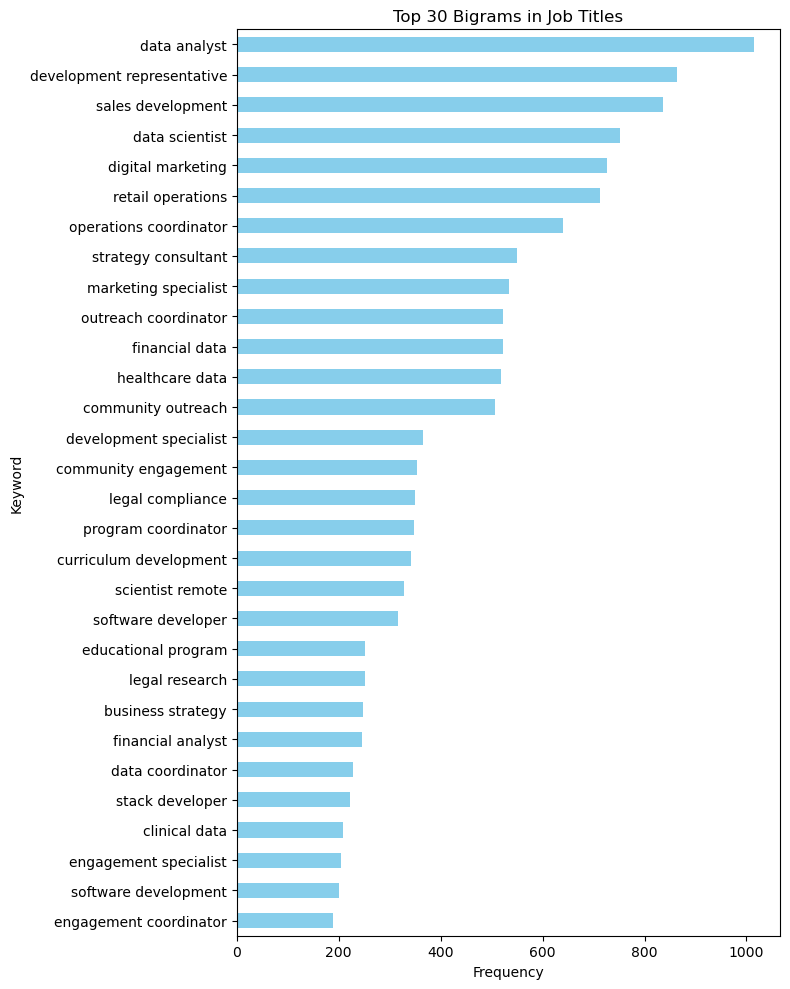

In [20]:
# --------------------------------------
# STEP 6: Bar Plot for top bigrams
# -------------------------------------- 
# => Plot top 30 keywords
plt.figure(figsize=(12, 10))  # Adjust size for better readability
top_bigrams_df[0:30].plot(kind='barh', x='bigram', y='count', legend=False, color='skyblue', figsize=(8, 10))
plt.title("Top 30 Bigrams in Job Titles")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.gca().invert_yaxis()  # Most frequent at top
plt.tight_layout()
plt.show()

---
## SECTION 3: Rule-based approach in categorizing job title

* In this section, I use a rule-based method to assign job titles to broader categories such as "Data Science", "Software Engineer", or "Marketing".
* This approach relies on **regular expressions (Regex)** to match specific keywords or patterns in the job title text. It's simple and interpretable, making it a good starting point for classification.

In [22]:
# --------------------------------------
# STEP 1: Define a dictionary where keywords map to broad job categories 
# -------------------------------------- 
##   Note that using regular expressions with boundary (\b) is important, 
##   because otherwise, for example, for "Data-related" jobs, 
##   categorization will capture any titles that contain letters "ai" (not the independent word "ai") in the job title.

rules = [
    # Data Science
    (r"\bdata\b.*\b(scientist|engineer|analyst|architect|specialist)\b", "data science"),
    (r"\b(machine learning|ml|ai|artificial intelligence)\b", "data science"),

    # Software Engineering
    (r"\b(software|frontend|web|ios|android|mobile application|stack|backend|ui)\b.*\b(engineer|developer)\b", "software engineering"),

    # Marketing
    (r"\b(marketing|brand|content|social media)\b", "marketing"),

    # Finance
    (r"\b(business|finance|financial|investment|accounting|bank|analyst)\b", "finance"),

    # Consulting
    (r"\bconsultant\b", "consulting"),

    # Sales
    (r"\b(sales|account executive|account manager|business development|inside sales|territory manager)\b", "sales"),

    # Retail
    (r"\b(retail|store|cashier|merchandiser|inventory)\b", "retail"),

    # Legal
    (r"\b(legal|lawyer|attorney|paralegal|counsel|compliance)\b", "legal"),

    # Public Sector
    (r"\b(public sector|government|municipal|policy analyst|city planner|civil service)\b", "public sector"),

    # Education
    (r"\b(teacher|professor|instructor|lecturer|tutor|education|academic|curriculum|principal)\b", "education"),

    # Healthcare
    (r"\b(healthcare|health|nurse|physician|medical|clinic|hospital|patient care|therapist|rn)\b", "healthcare"),
]

def categorize_job_title(title):
    if not isinstance(title, str):
        return "other"
    title = title.lower().strip()
    for pattern, label in rules:
        if re.search(pattern, title):
            return label
    return "other"

In [23]:
# --------------------------------------
# STEP 2: Apply this to the data
# -------------------------------------- 
posting_df["job_category"] = posting_df["job_title"].apply(categorize_job_title)

In [24]:
# --------------------------------------
# STEP 3: Examine job counts for each classified category
# --------------------------------------  
print(posting_df["job_category"].value_counts())

job_category
data science            2132
other                   2103
finance                 1379
sales                    963
marketing                933
software engineering     908
retail                   807
legal                    551
education                434
consulting               385
healthcare               282
Name: count, dtype: int64


In [25]:
# --------------------------------------
# STEP 4: Examine the "true" job category -- which is the sector used to generate job posting using LLM
# --------------------------------------   
print(posting_df['true_category'].value_counts())

true_category
data science            1054
public sector           1025
education               1014
sales                   1009
finance                  987
consulting               977
software engineering     972
retail                   970
marketing                962
healthcare               956
legal                    951
Name: count, dtype: int64


### 🔷 Comments:
* The distribution of rule-based job categories (`job_category`) differs noticeably from the original LLM-assigned categories (`sector`)—especially for categories like **education**, **healthcare**, and **legal**.
* To better understand where the rule-based classification succeeds or fails, I visualize the alignment between the predicted and true categories. 

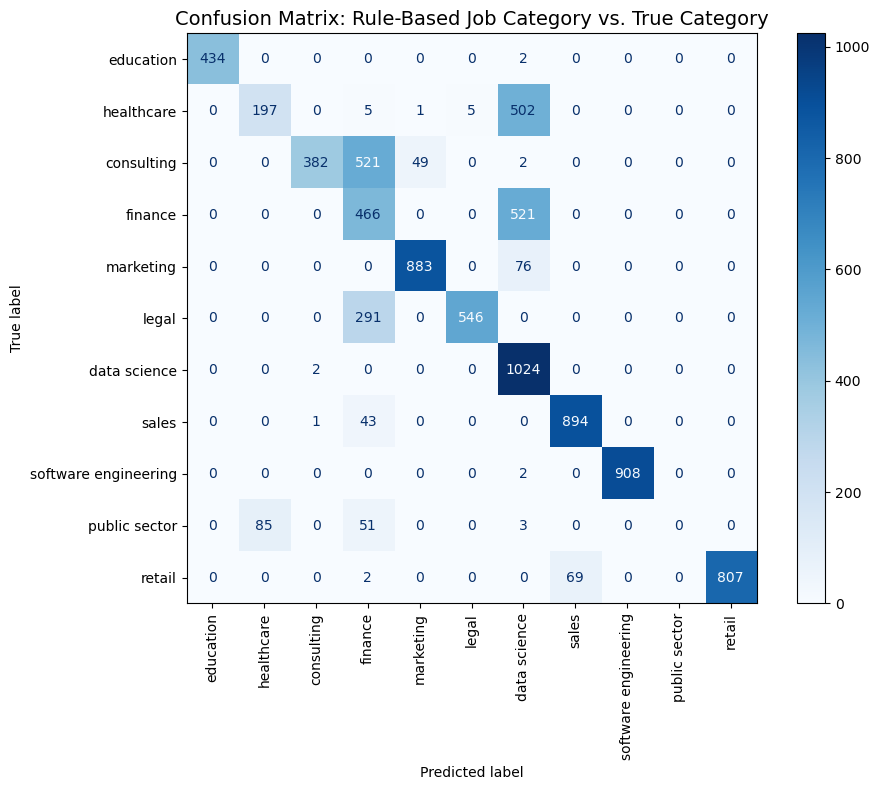

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(
    posting_df["true_category"],
    posting_df["job_category"],
    labels=posting_df["true_category"].unique()
)

# Plot with custom colormap and title
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=posting_df["true_category"].unique()
)

fig, ax = plt.subplots(figsize=(10, 8))  # Optional: adjust figure size
disp.plot(
    xticks_rotation=90,
    cmap="Blues", 
    ax=ax,
    colorbar=True
)
plt.title("Confusion Matrix: Rule-Based Job Category vs. True Category", fontsize=14)
plt.tight_layout()
plt.show()

### About the plot above ⬆️:

- How to interpret:
   * Each **row** represents the true job category (`true_category`), and each **column** shows the predicted category from the rule-based approach (`job_category`).
    *  A perfect classifier would produce a **diagonal matrix**, where predicted categories exactly match the true ones.
    *  **Off-diagonal values** indicate misclassifications—cases where the rule-based method failed to assign the correct label.
- We can see that rule-based approach works well for some categories, but not others.
  * For example, **software engineering** is classified accurately, with minimal confusion.
  * In contrast, categories like **education** and **data science** exhibit frequent misclassifications, highlighting the limitations of keyword-based rules.
- While the rule set is reasonable, this plot illustrates how **rule-based classification can struggle**, even on **synthetic data** that is cleaner than real-world postings.
- In the upcoming sections, we explore more robust alternatives: **supervised and unsupervised learning** techniques for job title classification.